In [40]:
import os
import numpy as np
import scipy as sp
from scipy.signal import find_peaks, savgol_filter
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
def parabola(x, a, b, x0):
    return a-b*(x-x0)**2

def linear(x, p, q):
    return x*p+q

In [42]:
hg=pd.read_csv('mercurio_5_1,52.txt', names=['vx', 'vy'])
hg['svy'] = savgol_filter(hg['vy'], 5, 2)
hg['err vx']=np.abs(hg['vx']*2e-2)
hg['err vy']=np.abs(hg['vy']*2e-2)

In [43]:
peaks_hg, _ =find_peaks(hg['svy'])
#peaks_hg=peaks_hg[hg['vx'].iloc[peaks_hg]>5]
hg['vx'].iloc[peaks_hg].diff().mean()

4.888

In [44]:
params_hg=[]
n=2
for p in peaks_hg:
    x=hg['vx'].iloc[p-n: p+n+1]
    y=hg['svy'].iloc[p-n: p+n+1]
    sigma=hg['err vy'].iloc[p-n: p+n+1]
    popt, pcov = curve_fit(parabola, x, y, p0=[1, 1, hg['vx'].iloc[p]], absolute_sigma=True, sigma = sigma)
    params_hg.append((popt, pcov, x))

In [45]:
params_hg=[]
n=2
for p in peaks_hg:
    delta=0.7
    xp=hg['vx'].iloc[p]
    mask1 = hg['vx'] < xp+delta
    mask2= hg['vx'] > xp-delta
    x=hg['vx'][np.logical_and(mask1, mask2)]
    y=hg['svy'][np.logical_and(mask1, mask2)]
    sigma=hg['err vy'][np.logical_and(mask1, mask2)]
    popt, pcov = curve_fit(parabola, x, y, p0=[1, 1, hg['vx'].iloc[p]], absolute_sigma=True, sigma = sigma)
    params_hg.append((popt, pcov, x))

In [46]:
[(curve[0][2], np.sqrt(np.diag(curve[1])[2])) for curve in params_hg]

[(2.5243686223130624, 0.02415092428203735),
 (7.104706442568731, 0.011654179383203442),
 (11.926247118063122, 0.020839072237343353),
 (16.802492598060226, 0.01870669449433335),
 (21.749709142758185, 0.028826794937135383),
 (26.792162365505913, 0.03410225098975794)]

In [47]:
from scipy.interpolate import make_interp_spline
bspl = make_interp_spline(hg['vx'], hg['vy'], k=3)
xx = np.linspace(5, hg['vx'].max(), 1000)
sp_peaks=find_peaks(bspl(xx))[0]
xx[sp_peaks]

array([ 7.18158158, 12.00672673, 16.83187187, 21.75967968, 26.79015015,
       29.84436436, 30.28068068])

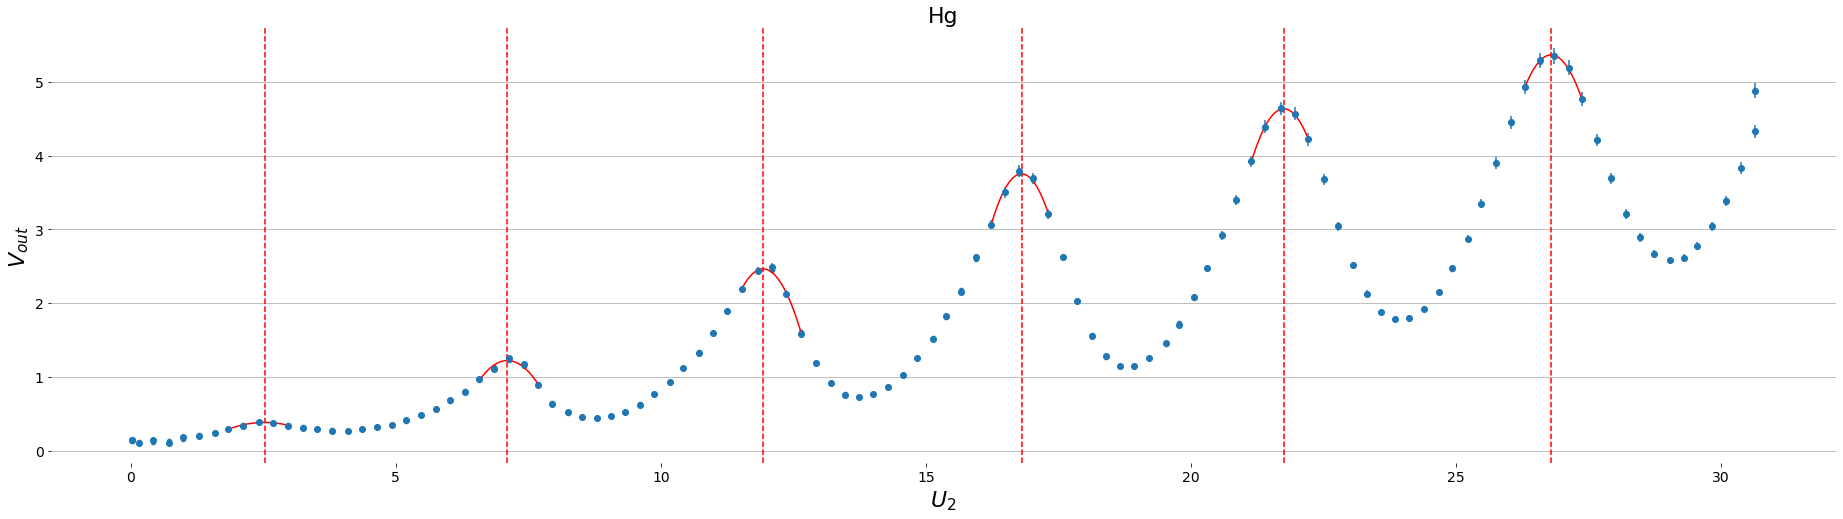

In [48]:
fig, ax1 = plt.subplots(nrows=1, ncols = 1, figsize = (32,8))
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
for curve in params_hg:
    x=np.linspace(curve[2].min(), curve[2].max(), 100)
    y=parabola(x, *curve[0])
    px=curve[0][2]
    sns.lineplot(x=x,y=y, ax=ax1, color = 'red')
    ax1.axvline(x=px, linestyle='--', color='red')
sns.scatterplot(hg, x='vx', y='svy', ax=ax1)
#sns.lineplot(x=xx, y=bspl(xx), ax=ax1)
ax1.errorbar(hg['vx'], hg['vy'], yerr=hg['err vy'], fmt='o')
ax1.set_xlabel(r'$U_2$', fontsize = 22)
ax1.set_ylabel(r"$V_{out}$", fontsize = 22)
ax1.set_title('Hg', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=14)
#ax1.set_xlim(left=5)
#plt.savefig('Hg.svg', bbox_inches = "tight")

In [49]:
Hg_p=pd.DataFrame(columns=['vx', 'err vx'], index=[1,2,3,4,5,6])
for curve, i in zip(params_hg, Hg_p.index):
    Hg_p.loc[i]=[curve[0][2], np.sqrt(np.diag(curve[1])[2])]
Hg_p['diff']=Hg_p['vx'].diff()
Hg_p['err diff']=(Hg_p['err vx']**2+Hg_p['err vx'].shift(1)**2).apply(lambda x : np.sqrt(x))
Hg_p

,vx,err vx,diff,err diff
1,2.524369,0.024151,NaN,NaN
2,7.104706,0.011654,4.580338,0.026816
3,11.926247,0.020839,4.821541,0.023876
4,16.802493,0.018707,4.876245,0.028004
5,21.749709,0.028827,4.947217,0.034365
6,26.792162,0.034102,5.042453,0.044654


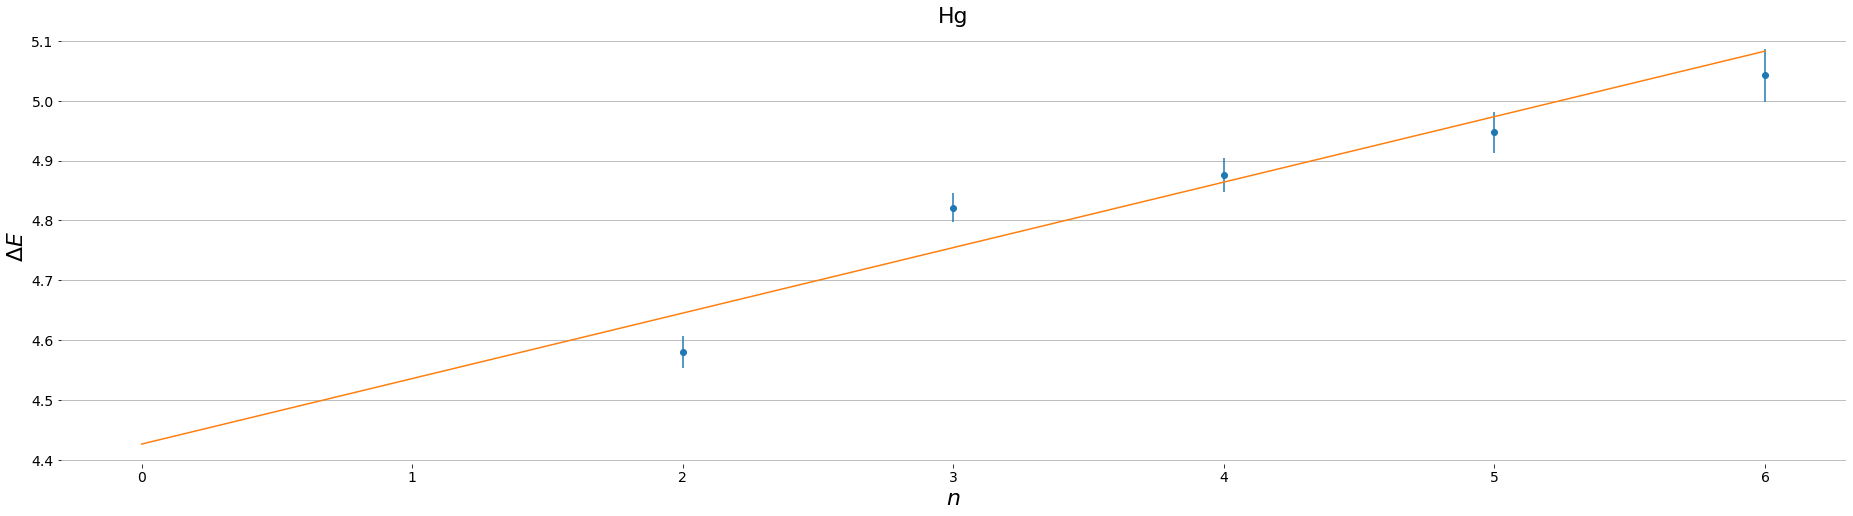

In [50]:
p0=np.ptp(Hg_p.dropna()['diff'])/4
xl=Hg_p.dropna().reset_index()['index']
yl=Hg_p.dropna().reset_index()['diff']
sy=Hg_p.dropna().reset_index()['err diff']
poptl, pcovl = curve_fit(linear, xl, yl, p0=[1, 0.1], absolute_sigma=True, sigma = sy)
x=np.linspace(0,6,1000)
y=linear(x,*poptl)
fig, ax1 = plt.subplots(nrows=1, ncols = 1, figsize = (32,8))
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.errorbar(xl, yl, yerr=sy, fmt='o')
sns.lineplot(x=x,y=y, ax=ax1)
ax1.set_xlabel(r'$n$', fontsize = 22)
ax1.set_ylabel(r"$\Delta E$", fontsize = 22)
ax1.set_title('Hg', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=14)

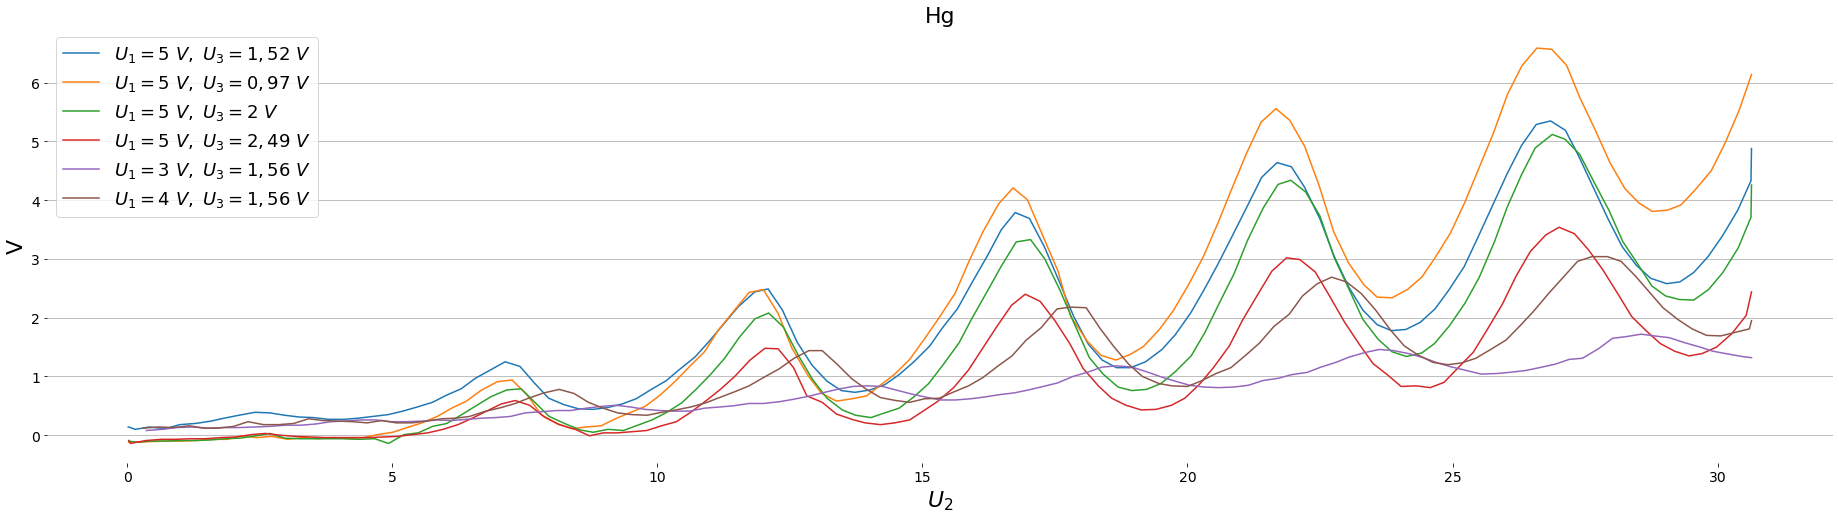

In [51]:
files=[x for x in os.listdir() if x.startswith('mercurio')]
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (32,8))
ax.grid(axis = 'y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Hg', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel(r'$U_2$', fontsize = 22)
ax.set_ylabel("V", fontsize = 22)
for file in files:
    u1=file.split('_')[1]
    u3=file.split('_')[2].strip('.txt')
    temp=pd.read_csv(file, names=['vx', 'vy'])
    temp['svy'] = savgol_filter(temp['vy'], 5, 2)
    temp['err vx']=temp['vx']*2e-2
    temp['err vy']=temp['vy']*2e-2
    sns.lineplot(temp, x='vx', y='vy', ax=ax, label=fr'$U_1 = {u1}\ V,\ U_3 = {u3}\ V$')
ax.legend(fontsize=18)
#plt.savefig('Hg_generale.svg', bbox_inches = "tight")

[(17.114110461625323, 0.04069077662524663),
 (34.62807649002375, 0.060373325800171664),
 (53.571863234775975, 0.15247438717713876),
 (74.99571421135143, 0.34028364471426464)]

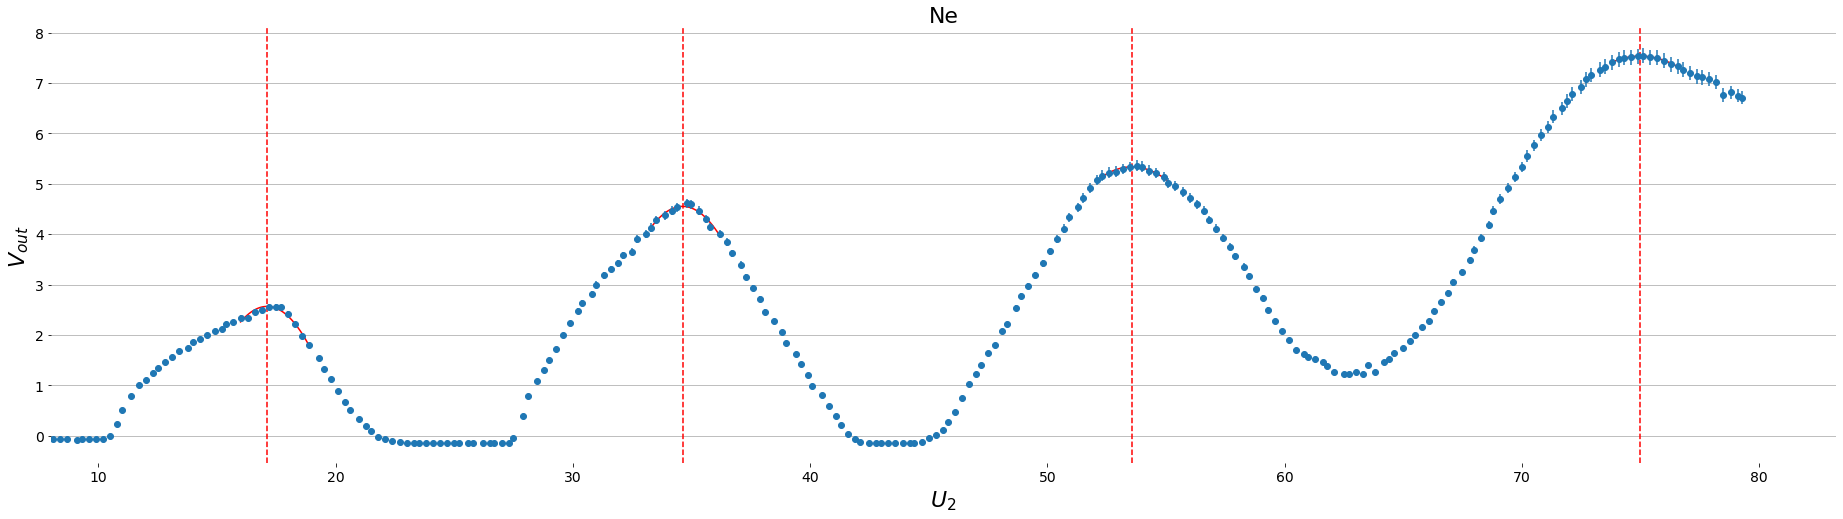

In [52]:
ne=pd.read_csv('neon_2,03_10,37.txt', names=['vx', 'vy'])
#ne=ne[ne['vx']<70]
ne['svy'] = savgol_filter(ne['vy'], 7, 2)
ne['err vx']=ne['vx']*2e-2
ne['err vy']=np.abs(ne['vy']*2e-2)
peaks_ne, _ =find_peaks(ne['svy'], threshold=0.001)
peaks_ne=peaks_ne[ne['vx'].iloc[peaks_ne]>10]
ne['vx'].iloc[peaks_ne].diff().mean()
params_ne=[]
n=5
for p in peaks_ne:
    x=ne['vx'].iloc[p-n: p+n+1]
    y=ne['svy'].iloc[p-n: p+n+1]
    sigma=ne['err vy'].iloc[p-n: p+n+1]
    popt, pcov = curve_fit(parabola, x, y, p0=[1, 1, ne['vx'].iloc[p]], absolute_sigma=True, sigma = sigma)
    params_ne.append((popt, pcov, x))
fig, ax1 = plt.subplots(nrows=1, ncols = 1, figsize = (32,8))
ax1.grid(axis = 'y')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
for curve in params_ne:
    x=np.linspace(curve[2].min(), curve[2].max(), 100)
    y=parabola(x, *curve[0])
    px=curve[0][2]
    sns.lineplot(x=x,y=y, ax=ax1, color = 'red')
    ax1.axvline(x=px, linestyle='--', color='red')
#sns.scatterplot(ne, x='vx', y='svy', ax=ax1)
ax1.errorbar(ne['vx'], ne['vy'], yerr=ne['err vy'], fmt='o')
ax1.set_xlabel(r'$U_2$', fontsize = 22)
ax1.set_ylabel(r"$V_{out}$", fontsize = 22)
ax1.set_title(r'Ne', fontsize=22)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlim(left=8)
#plt.savefig('Ne.svg', bbox_inches = "tight")
[(curve[0][2], np.sqrt(np.diag(curve[1])[2])) for curve in params_ne]

In [53]:
Ne_p=pd.DataFrame(columns=['vx', 'err vx'], index=[1,2,3,4])
for curve, i in zip(params_ne, Ne_p.index):
    Ne_p.loc[i]=[curve[0][2], np.sqrt(np.diag(curve[1])[2])]
Ne_p['diff']=Ne_p['vx'].diff()
Ne_p['err diff']=(Ne_p['err vx']**2+Ne_p['err vx'].shift(1)**2).apply(lambda x : np.sqrt(x))
Ne_p

,vx,err vx,diff,err diff
1,17.11411,0.040691,NaN,NaN
2,34.628076,0.060373,17.513966,0.072806
3,53.571863,0.152474,18.943787,0.163992
4,74.995714,0.340284,21.423851,0.372883


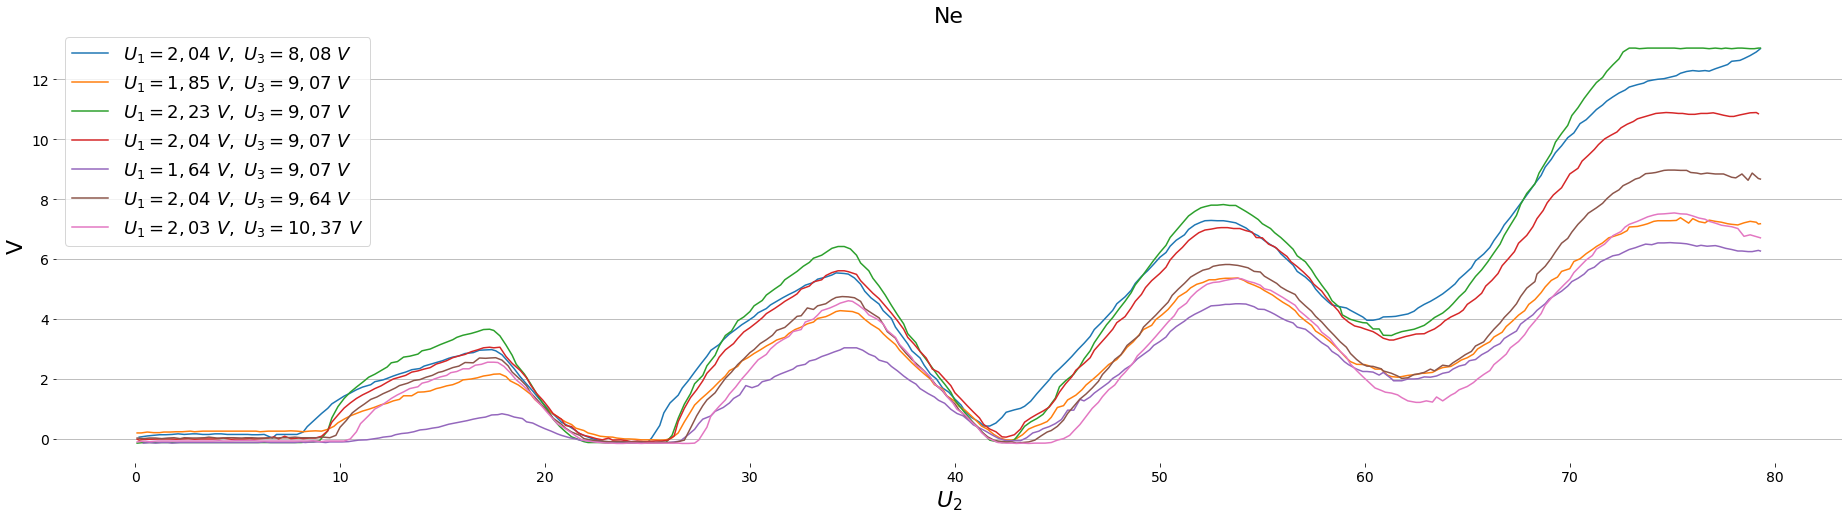

In [54]:
files=[x for x in os.listdir() if x.startswith('neon')]
fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (32,8))
ax.grid(axis = 'y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Ne', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel(r'$U_2$', fontsize = 22)
ax.set_ylabel("V", fontsize = 22)
for file in files:
    u1=file.split('_')[1]
    u3=file.split('_')[2].strip('.txt')
    temp=pd.read_csv(file, names=['vx', 'vy'])
    temp['svy'] = savgol_filter(temp['vy'], 5, 2)
    temp['err vx']=temp['vx']*2e-2
    temp['err vy']=temp['vy']*2e-2
    sns.lineplot(temp, x='vx', y='vy', ax=ax, label=fr'$U_1 = {u1}\ V,\ U_3 = {u3}\ V$')
ax.legend(fontsize=18)
#plt.savefig('Ne_gen.svg', bbox_inches = "tight")